### Prérequis

In [1]:
# conda create -n llm python=3.9
# python.exe -m pip install --upgrade pip
# pip install --upgrade transformers datasets[audio] accelerate
# pip install --upgrade evaluate jiwer matplotlib seaborn
# conda install -n llm ipykernel --update-deps --force-reinstall

### Imports

In [2]:
import librosa
import pickle
import time
import evaluate
import jiwer
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from transformers import (
    AutoModelForSpeechSeq2Seq,
    AutoProcessor,
    pipeline,
    WhisperProcessor,
)
import joblib
import pandas as pd

c:\Users\beranger\anaconda3\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Variables préparatoires

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

wer_metric = evaluate.load("wer")

model_ids = [
    "openai/whisper-tiny",
    "openai/whisper-base",
    "openai/whisper-small",
    "openai/whisper-medium",
    "openai/whisper-large",
    "openai/whisper-large-v2",
    "openai/whisper-large-v3",
    "openai/whisper-large-v3-turbo",
]

# model_ids = [
#     "openai/whisper-tiny",
#     "openai/whisper-base",
#     "openai/whisper-small",
#     "openai/whisper-medium"
# ]

### Textes

In [4]:
# Textes lus
texts = {
    "fr": "Mme Verdurin fut outrée quand elle apprit que deux membres du petit groupe étaient invités sans elle à dîner à Féterne « en petit comité ». Elle dicta au docteur, dont le premier mouvement avait été d'accepter, une fière réponse où il disait : « Nous dînons ce soir-là chez Mme Verdurin », pluriel qui devait être une leçon pour les Cambremer et leur montrer qu'il n'était pas séparable de Mme Cottard. Quant à Morel, Mme Verdurin n'eut pas besoin de lui tracer une conduite impolie, qu'il tint spontanément, voici pourquoi. S'il avait, à l'égard de M. de Charlus, en ce qui concernait ses plaisirs, une indépendance qui affligeait le baron, nous avons vu que l'influence de ce dernier se faisait sentir davantage dans d'autres domaines et qu'il avait par exemple élargi les connaissances musicales et rendu plus pur le style du virtuose. Mais ce n'était encore, au moins à ce point de notre récit, qu'une influence. En revanche, il y avait un terrain sur lequel ce que disait M. de Charlus était aveuglément cru et exécuté par Morel. Aveuglément et follement, car non seulement les enseignements de M. de Charlus étaient faux, mais encore, eussent-ils été valables pour un grand seigneur, appliqués à la lettre par Morel ils devenaient burlesques.",
    "en": "It was a bright cold day in April, and the clocks were striking thirteen. Winston Smith, his chin nuzzled into his breast in an effort to escape the vile wind, slipped quickly through the glass doors of Victory Mansions, though not quickly enough to prevent a swirl of gritty dust from entering along with him. The hallway smelt of boiled cabbage and old rag mats. At one end of it a coloured poster, too large for indoor display, had been tacked to the wall. It depicted simply an enormous face, more than a metre wide: the face of a man of about forty-five, with a heavy black moustache and ruggedly handsome features. Winston made for the stairs. It was no use trying the lift. Even at the best of times it was seldom working, and at present the electric current was cut off during daylight hours. It was part of the economy drive in preparation for Hate Week. The flat was seven flights up, and Winston, who was thirty-nine and had a varicose ulcer above his right ankle, went slowly, resting several times on the way. On each landing, opposite the lift-shaft, the poster with the enormous face gazed from the wall. It was one of those pictures which are so contrived that the eyes follow you about when you move. BIG BROTHER IS WATCHING YOU, the caption beneath it ran.",
    "es": "En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lantejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas, con sus pantuflos de lo mesmo, y los días de entresemana se honraba con su vellorí de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años; era de complexión recia, seco de carnes, enjuto de rostro, gran madrugador y amigo de la caza. Quieren decir que tenía el sobrenombre de Quijada, o Quesada, que en esto hay alguna diferencia en los autores que deste caso escriben; aunque, por conjeturas verosímiles, se deja entender que se llamaba Quejana. Pero esto importa poco a nuestro cuento; basta que en la narración dél no se salga un punto de la verdad.",
    "de": "Als Gregor Samsa eines Morgens aus unruhigen Träumen erwachte, fand er sich in seinem Bett zu einem ungeheueren Ungeziefer verwandelt. Er lag auf seinem panzerartig harten Rücken und sah, wenn er den Kopf ein wenig hob, seinen gewölbten, braunen, von bogenförmigen Versteifungen geteilten Bauch, auf dessen Höhe sich die Bettdecke, zum gänzlichen Niedergleiten bereit, kaum noch erhalten konnte. Seine vielen, im Vergleich zu seinem sonstigen Umfang kläglich dünnen Beine flimmerten ihm hilflos vor den Augen. »Was ist mit mir geschehen?«, dachte er. Es war kein Traum. Sein Zimmer, ein richtiges, nur etwas zu kleines Menschenzimmer, lag ruhig zwischen den vier wohlbekannten Wänden. Über dem Tisch, auf dem eine auseinandergepackte Musterkollektion von Tuchwaren ausgebreitet war – Samsa war Reisender – hing das Bild, das er vor kurzem aus einer illustrierten Zeitschrift ausgeschnitten und in einem hübschen, vergoldeten Rahmen untergebracht hatte. Es stellte eine Dame dar, die mit einem Pelzhut und einer Pelzboa versehen, aufrecht dasaß und einen schweren Pelzmuff, in dem ihr ganzer Unterarm verschwunden war, dem Beschauer entgegenhob.",
}

### Lister les fichiers audio disponibles selon les langues paramétrées
La syntaxe des fichiers audio doit être :
    {langue}_0.wav

Par exemple :
    fr_0.wav est le fichier de qualité maximale contenant l'audio à transcrire pour le Français.
    de_0.wav est le fichier de qualité maximale contenant l'audio à transcrire pour l'Allemand.

Le programme se chargera de créer les fichiers de qualités dégradées à l'aide d'un plugin vst.

In [5]:
# Recherche des langues souhaitées
langues = texts.keys()

# Recherche des fichiers audio correspondants
audio_files = {
    l: [
        f
        for f in Path("audio").glob(f"{l}_*_norm*.wav")
        if f.is_file() and f.stat().st_size > 0
    ]
    for l in langues
}

# Mise à jour des langues, selon les fichiers trouvés dans le répertoire audio
langues = list(audio_files.keys())

# Initialisation de la variables resultat
if not langues:
    print("Aucun fichier audio trouvé dans le répertoire 'audio'")
else:
    # Créer un dictionnaire de résultats en tenant compte de chaque fichier présent dans "audio"
    results = {
        langue: {
            model_id: {f: {} for f in audio_files[langue]} for model_id in model_ids
        }
        for langue in langues
    }
    print(f"Langues : {langues}")
    print(results)

Langues : ['fr', 'en', 'es', 'de']
{'fr': {'openai/whisper-tiny': {WindowsPath('audio/fr_0_norm_+2.7db.wav'): {}, WindowsPath('audio/fr_1_norm_+1.9db.wav'): {}, WindowsPath('audio/fr_2_norm_+7.7db.wav'): {}, WindowsPath('audio/fr_3_norm_+0.3db.wav'): {}, WindowsPath('audio/fr_4_norm_+6.7db.wav'): {}, WindowsPath('audio/fr_5_norm_+3.0db.wav'): {}, WindowsPath('audio/fr_6_norm_-1.2db.wav'): {}, WindowsPath('audio/fr_7_norm_+4.5db.wav'): {}, WindowsPath('audio/fr_8_norm_+9.8db.wav'): {}}, 'openai/whisper-base': {WindowsPath('audio/fr_0_norm_+2.7db.wav'): {}, WindowsPath('audio/fr_1_norm_+1.9db.wav'): {}, WindowsPath('audio/fr_2_norm_+7.7db.wav'): {}, WindowsPath('audio/fr_3_norm_+0.3db.wav'): {}, WindowsPath('audio/fr_4_norm_+6.7db.wav'): {}, WindowsPath('audio/fr_5_norm_+3.0db.wav'): {}, WindowsPath('audio/fr_6_norm_-1.2db.wav'): {}, WindowsPath('audio/fr_7_norm_+4.5db.wav'): {}, WindowsPath('audio/fr_8_norm_+9.8db.wav'): {}}, 'openai/whisper-small': {WindowsPath('audio/fr_0_norm_+2.7db.

### Boucles de transcription

In [6]:
# Boucle de traitement par langue et par modèle
for l in langues:
    for f in audio_files:
        
    print(f"Testing file {f}...")
    audio_data_test, sr_test = librosa.load(f, sr=16000)
    results[l][f] = {}
    for model in model_ids:
        model_name = model.split("/")[-1].split("-", maxsplit=1)[1]
        results[l][f][model_name] = {}
        print(f"Testing model {model}...")
        start_time = time.time()
        tmp_model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
        ).to(device)
        tmp_processor = AutoProcessor.from_pretrained(model)
        tmp_pipe = pipeline(
            "automatic-speech-recognition",
            model=tmp_model,
            tokenizer=tmp_processor.tokenizer,
            feature_extractor=tmp_processor.feature_extractor,
            torch_dtype=torch_dtype,
            device=device,
            return_timestamps=True,
        )

        output = tmp_pipe(audio_data_test)
        elapsed = time.time() - start_time
        wer_value = wer_metric.compute(
            predictions=[output["text"]], references=[texte_original]
        )

        results[l][f][model_name].update(
            {"transcription": output["text"], "wer": wer_value, "time_s": elapsed}
        )

NameError: name 'f' is not defined

### Enregistrement des résultats

In [ ]:
# Enregistrer la variable results dans un fichier pickle
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)

# Enregistrer la variable results dans un fichier joblib
joblib.dump(results, "results.joblib")

# Enregistrer la variable results dans un fichier csv
results_df = pd.DataFrame(results)
results_df.to_csv("results.csv")

### Exploitation 1 des résultats

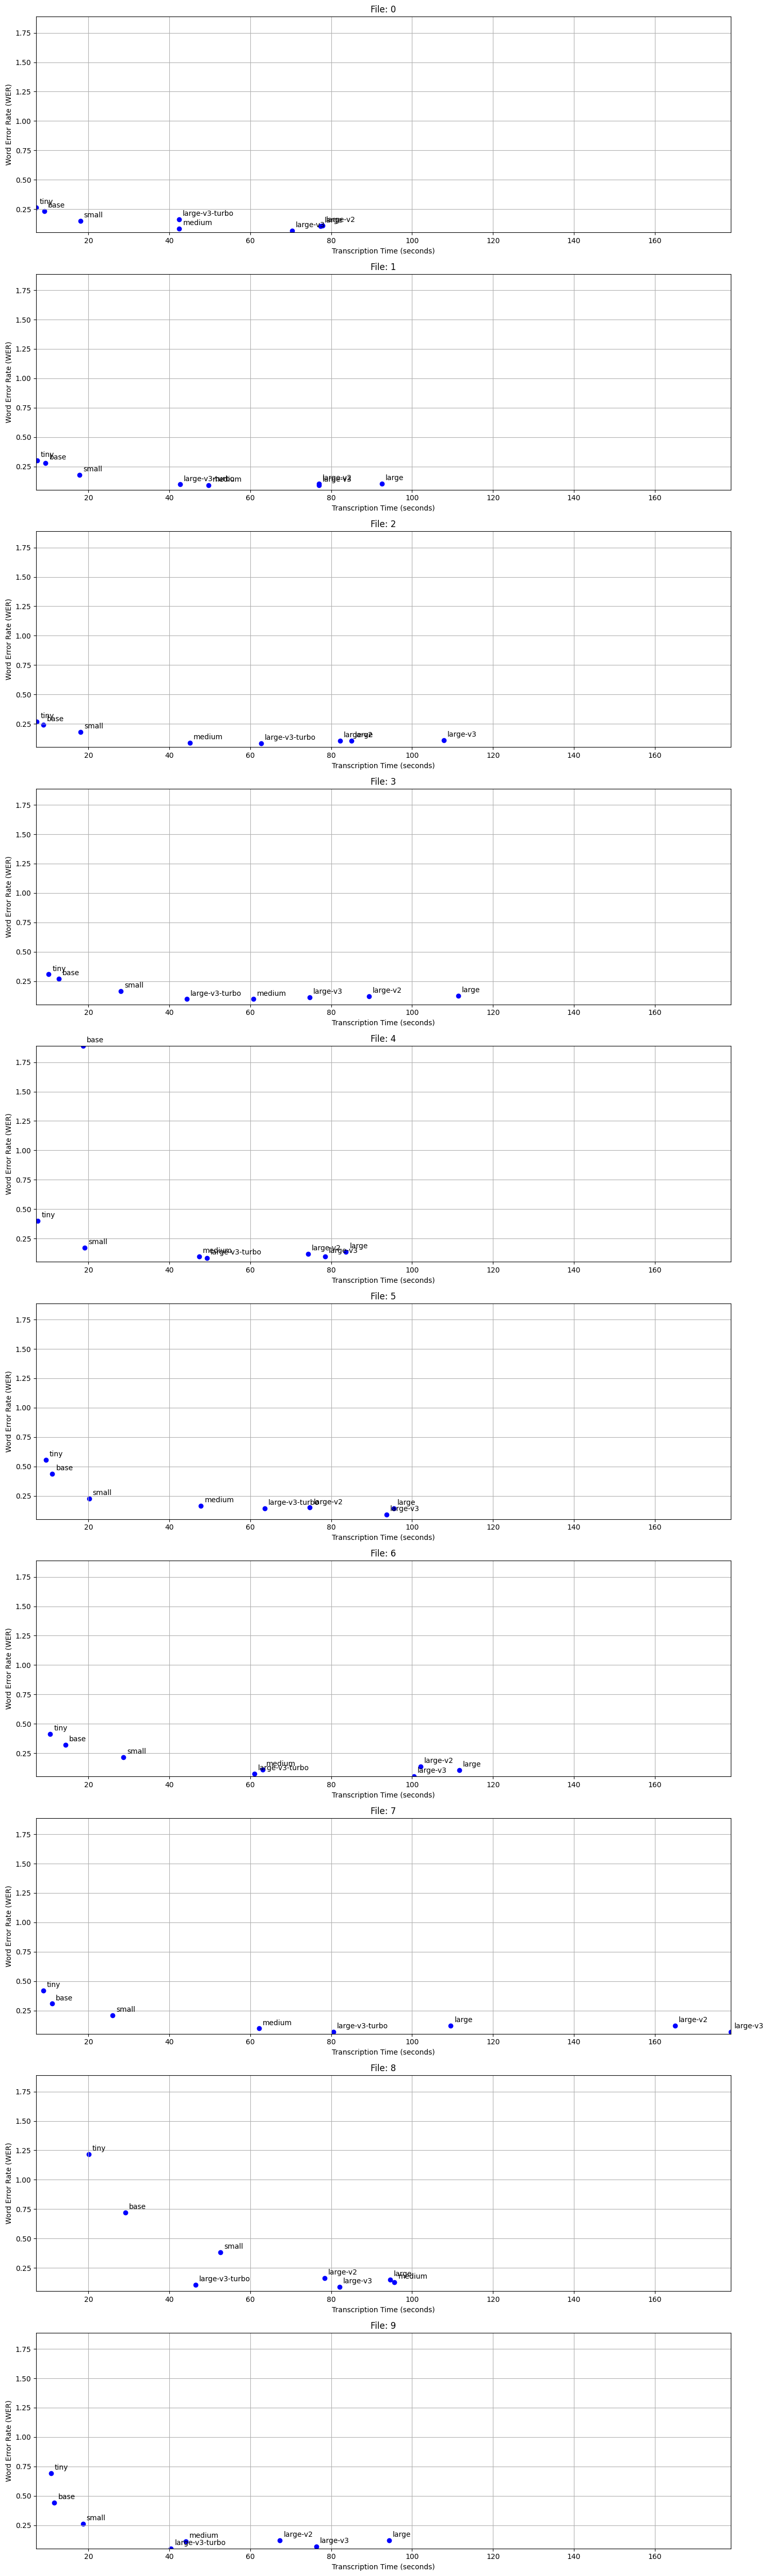

In [5]:
# Calculate number of rows needed for subplots
n_files = len(results)
n_cols = 1  # Set to 1 for a single column
n_rows = n_files

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = [axes]  # Ensure axes is iterable

# Find global min and max for times and wer_scores
all_times = [
    data["time_s"] for models_data in results.values() for data in models_data.values()
]
all_wer_scores = [
    data["wer"] for models_data in results.values() for data in models_data.values()
]

min_time, max_time = min(all_times), max(all_times)
min_wer, max_wer = min(all_wer_scores), max(all_wer_scores)

for file_idx, (file, models_data) in enumerate(results.items()):
    ax = axes[file_idx]

    wer_scores = [data["wer"] for data in models_data.values()]
    times = [data["time_s"] for data in models_data.values()]
    model_names = list(models_data.keys())

    ax.scatter(times, wer_scores, color="blue")

    # Add model name annotations
    for i, model in enumerate(model_names):
        ax.annotate(
            model, (times[i], wer_scores[i]), xytext=(5, 5), textcoords="offset points"
        )

    ax.set_xlabel("Transcription Time (seconds)")
    ax.set_ylabel("Word Error Rate (WER)")
    ax.set_title(f"File: {file.stem}")
    ax.grid(True)

    # Set same scale for all subplots
    ax.set_xlim(min_time, max_time)
    ax.set_ylim(min_wer, max_wer)

plt.tight_layout()
plt.show()

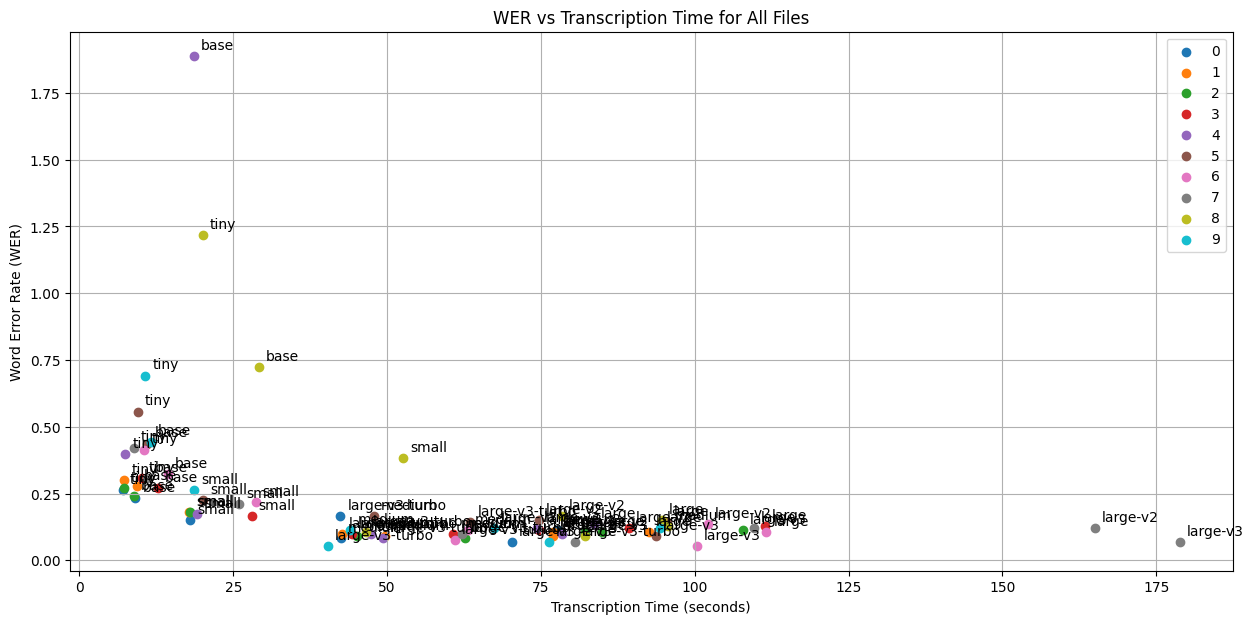

In [6]:
# Create figure
plt.figure(figsize=(15, 7))

# Define a color palette
colors = plt.cm.tab10.colors  # up to 10 colors

for file_idx, (file, models_data) in enumerate(results.items()):
    wer_scores = [data["wer"] for data in models_data.values()]
    times = [data["time_s"] for data in models_data.values()]
    model_names = list(models_data.keys())
    color = colors[file_idx % len(colors)]

    plt.scatter(times, wer_scores, color=color, label=file.stem)

    # Add model name annotations
    for i, model in enumerate(model_names):
        plt.annotate(
            model, (times[i], wer_scores[i]), xytext=(5, 5), textcoords="offset points"
        )

plt.xlabel("Transcription Time (seconds)")
plt.ylabel("Word Error Rate (WER)")
plt.title("WER vs Transcription Time for All Files")
plt.legend()
plt.grid(True)
plt.show()

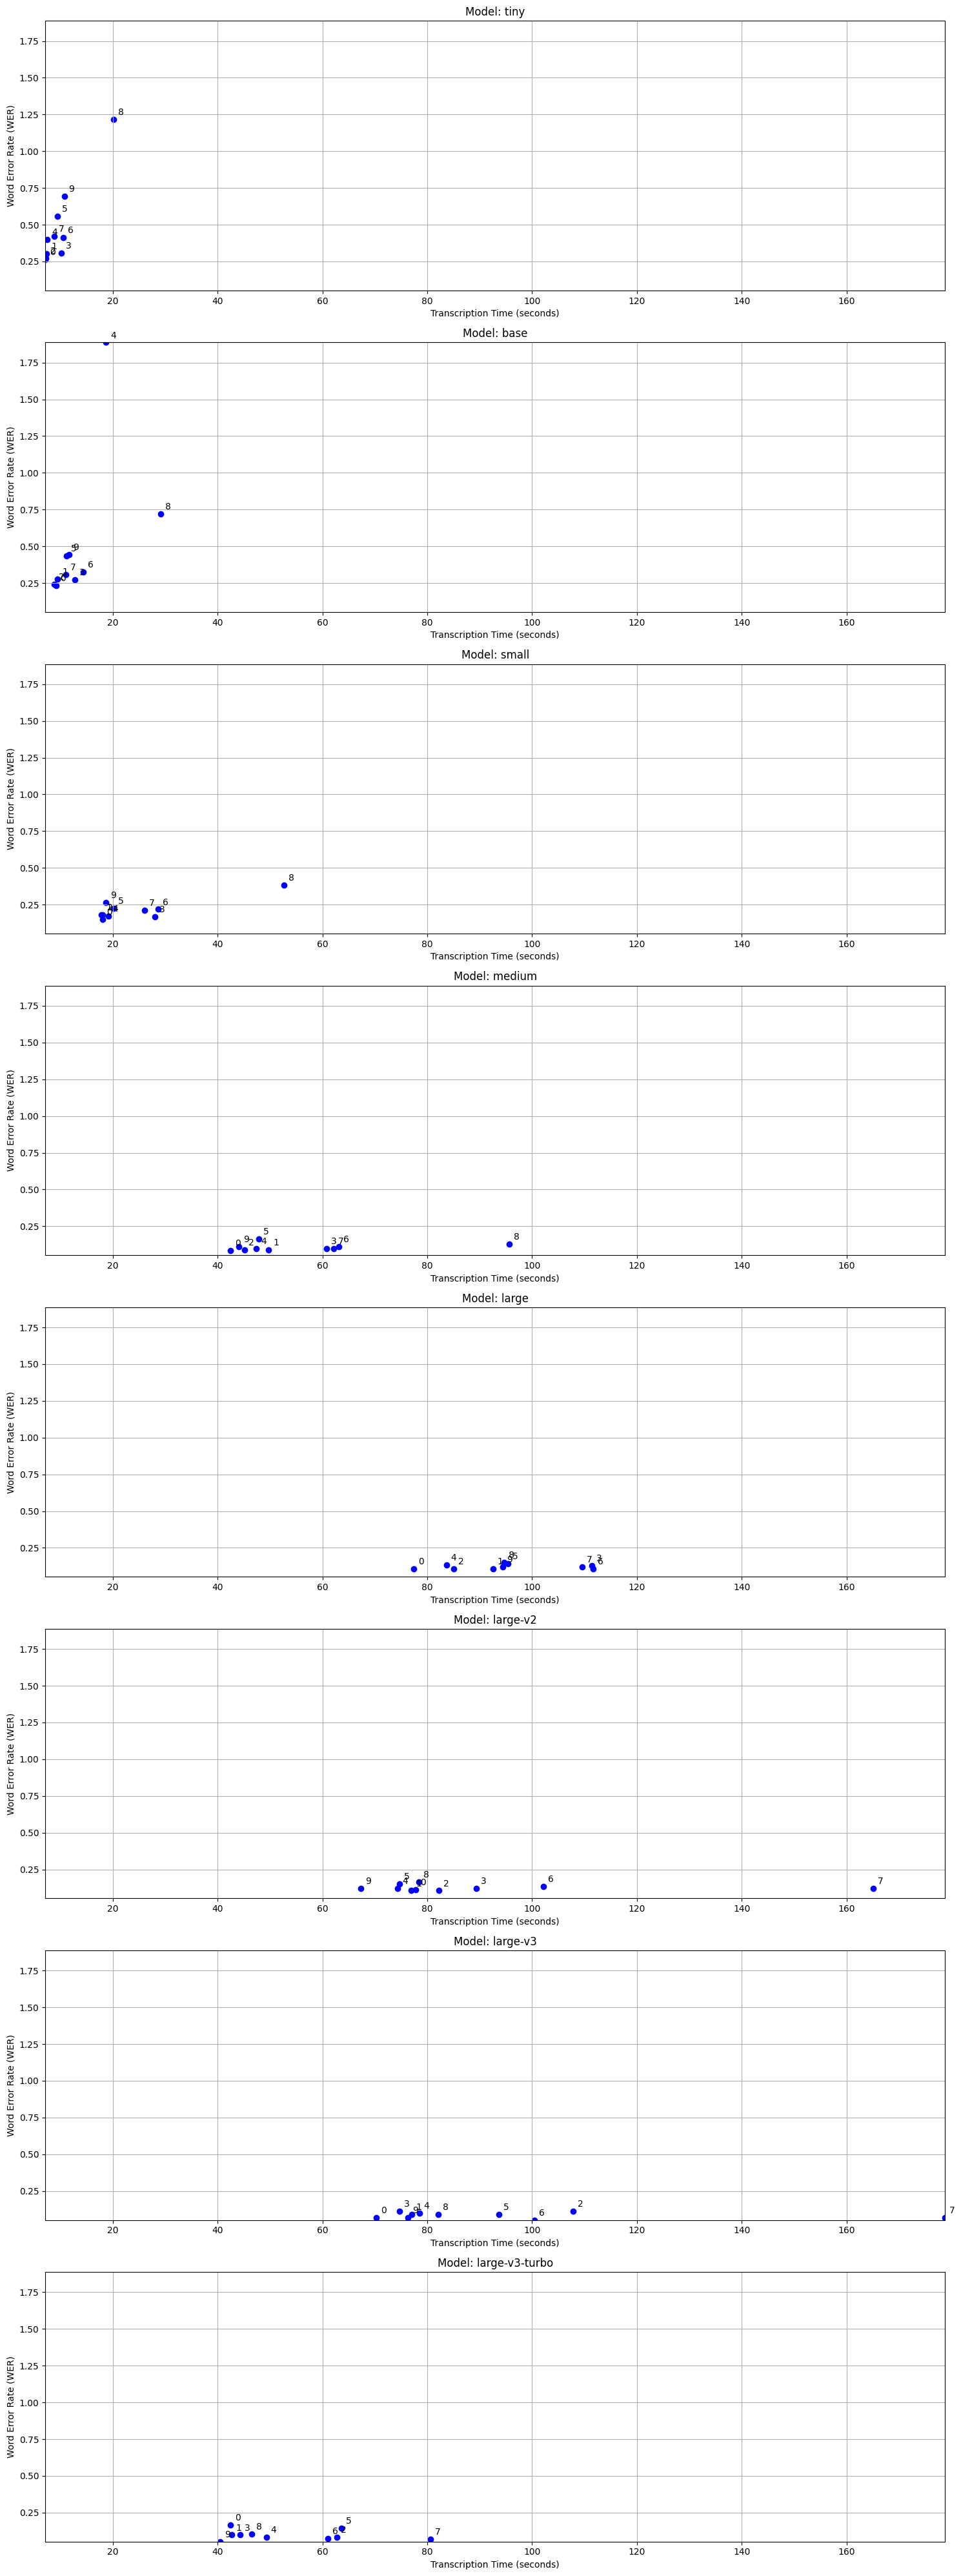

In [7]:
# Extract unique model names
model_names = list(results[next(iter(results))].keys())

# Calculate number of rows needed for subplots
n_models = len(model_names)
n_cols = 1  # Set to 1 for a single column
n_rows = n_models

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = [axes]  # Ensure axes is iterable

for model_idx, model in enumerate(model_names):
    ax = axes[model_idx]

    times = [results[file][model]["time_s"] for file in results]
    wer_scores = [results[file][model]["wer"] for file in results]
    file_names = [file.stem for file in results]

    ax.scatter(times, wer_scores, color="blue")

    # Add file name annotations
    for i, file_name in enumerate(file_names):
        ax.annotate(
            file_name,
            (times[i], wer_scores[i]),
            xytext=(5, 5),
            textcoords="offset points",
        )

    ax.set_xlabel("Transcription Time (seconds)")
    ax.set_ylabel("Word Error Rate (WER)")
    ax.set_title(f"Model: {model}")
    ax.grid(True)

    # Set same scale for all subplots
    ax.set_xlim(min_time, max_time)
    ax.set_ylim(min_wer, max_wer)

plt.tight_layout()
plt.show()

### Exploitation 2 des résultats

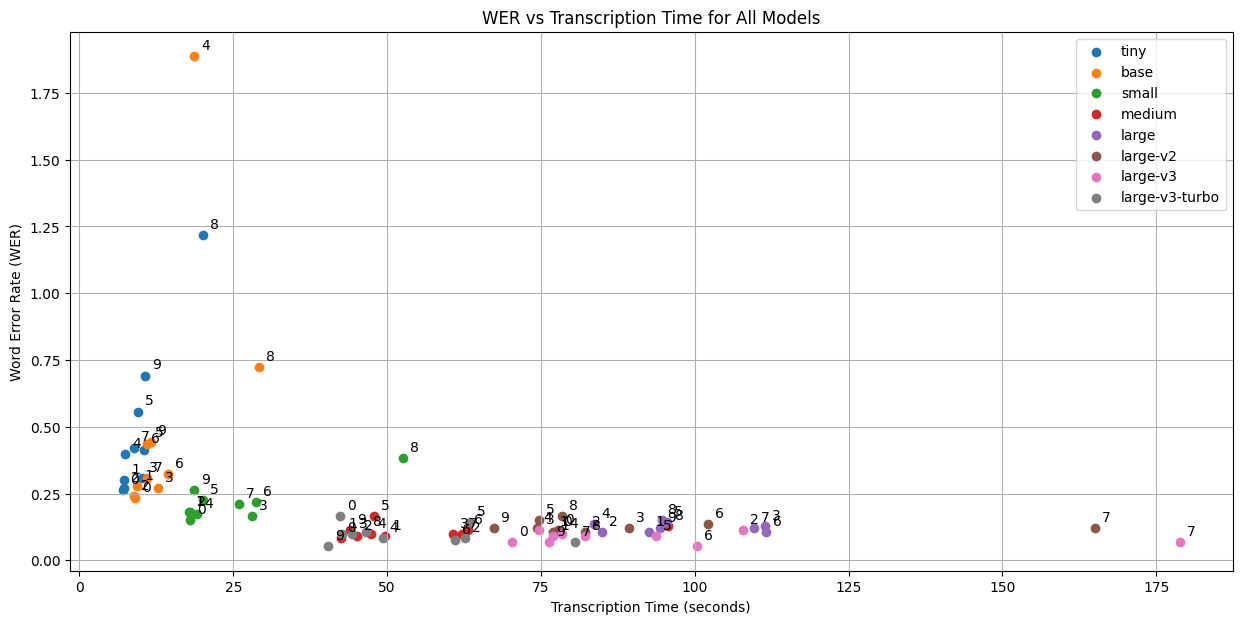

In [8]:
# Extract unique model names
model_names = list(results[next(iter(results))].keys())

# Define a color palette
colors = plt.cm.tab10.colors  # up to 10 colors

# Create figure
plt.figure(figsize=(15, 7))

for model_idx, model in enumerate(model_names):
    times = [results[file][model]["time_s"] for file in results]
    wer_scores = [results[file][model]["wer"] for file in results]
    file_names = [file.stem for file in results]
    color = colors[model_idx % len(colors)]

    plt.scatter(times, wer_scores, color=color, label=model)

    # Add file name annotations
    for i, file_name in enumerate(file_names):
        plt.annotate(
            file_name,
            (times[i], wer_scores[i]),
            xytext=(5, 5),
            textcoords="offset points",
        )

plt.xlabel("Transcription Time (seconds)")
plt.ylabel("Word Error Rate (WER)")
plt.title("WER vs Transcription Time for All Models")
plt.legend()
plt.grid(True)
plt.show()